In [ ]:
G = load_network('A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.50_prs_0.02.net')

In [119]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from infomap import Infomap
import numpy as np
import community as community_louvain
import leidenalg as la
import igraph as ig
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

def load_network(file_path):
    # Load a network from a Pajek .net file
    G = nx.read_pajek(file_path)
    # Convert the network to an undirected graph, if necessary
    if isinstance(G, nx.DiGraph):
        G = G.to_undirected()
    # Pajek files often label nodes with strings, ensure they are consistent integers if needed
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    return G

def detect_communities(G, method='louvain'):
    if method == 'louvain':
        partition = community_louvain.best_partition(G)
    elif method == 'infomap':
        infomap = Infomap()
        # Ensure that node labels are converted to integers if they are not already
        for edge in G.edges():
            u, v = map(int, edge)  # Convert edge endpoints to integers
            infomap.add_link(u, v)
        infomap.run()
        # Mapping node to module with proper node type handling
        partition = {int(node): module for node, module in infomap.get_modules().items()}
    elif method == 'agglomerative':
        linkage_matrix = linkage(pdist(nx.to_numpy_array(G)), method='ward')
        cutoff = 1.5  
        # Determine clusters from the linkage matrix Z at a given cutoff
        clusters = fcluster(linkage_matrix, cutoff, criterion='distance')
        # Create a partition dictionary mapping nodes to their cluster
        partition = {node: clusters[i] for i, node in enumerate(G.nodes())}
    elif method == 'leiden':
        # Convert NetworkX graph to an igraph graph
        ig_graph = ig.Graph.TupleList(G.edges(), directed=False)
        partition = la.find_partition(ig_graph, la.ModularityVertexPartition)
        # Convert partition to the same format used in NetworkX
        partition = {node.index: partition.membership[node.index] for node in ig_graph.vs}
    else:
        raise ValueError("Unsupported method: Choose 'louvain' or 'infomap'")
    return partition

def visualize_communities(G, partition, title):
    if not all(node in partition for node in G.nodes()):
        missing_nodes = [node for node in G.nodes() if node not in partition]
        print(f"Warning: Nodes missing in partition: {missing_nodes}")
        for node in missing_nodes:
            partition[node] = -1  # Assigning a default community for missing nodes
    
    # Ensure node labels are consistent for mapping colors
    unique_communities = list(set(partition.values()))
    if "Agglomerative" in title:
        community_index = {node: community for node, community in partition.items()}
        colors = [community_index.get(node, 0) for node in G.nodes()]
    else:
        community_index = {comm: idx for idx, comm in enumerate(unique_communities)}
        colors = [community_index[partition[node]] for node in G.nodes()]

    # Generate position map for consistent node positions
    pos = nx.spring_layout(G, seed=42)  # Use a fixed seed for reproducible layout

    # Create a new figure and Axes for drawing
    fig, ax = plt.subplots(figsize=(10, 8))
    cmap = plt.get_cmap('viridis', len(unique_communities))
    
    # Drawing the nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=colors, cmap=cmap, node_size=40, alpha=0.8)
    
    # Drawing the edges
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.5)

    # Setting up the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.025, pad=0.05)
    cbar.set_label('Community ID')

    ax.set_title(title)
    ax.axis('off')  # Turn off the axis
    
    plt.show()
    
def jaccard_index(set1, set2):
    """Calculate the Jaccard Index between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    else:
        return intersection / union

def partition_to_sets(partition):
    """Convert a partition dictionary to a list of sets."""
    from collections import defaultdict
    community_dict = defaultdict(set)
    for node, community in partition.items():
        community_dict[community].add(node)
    return list(community_dict.values())

from sklearn.metrics import jaccard_score

def compare_communities(community_sets_true, community_sets_computed):
    """Compare two lists of community sets and return average Jaccard Index."""
    jaccard_scores = []
    for set_true in community_sets_true:
        max_jaccard = 0
        for set_computed in community_sets_computed:
            score = jaccard_index(set_true, set_computed)
            if score > max_jaccard:
                max_jaccard = score
        jaccard_scores.append(max_jaccard)
    return sum(jaccard_scores) / len(jaccard_scores) if jaccard_scores else 0

def calculate_metrics(true_partition, detected_partition):
    # Convert partition dictionaries to lists of community labels
    true_labels = [true_partition[node] for node in sorted(true_partition)]
    detected_labels = [detected_partition[node] for node in sorted(detected_partition)]
    nmi = normalized_mutual_info_score(true_labels, detected_labels)
    ari = adjusted_rand_score(true_labels, detected_labels)
    
    true_sets = partition_to_sets(true_partition)
    computed_sets = partition_to_sets(detected_partition)
    jaccard_idx = compare_communities(true_sets, computed_sets)
    
    return nmi, ari, jaccard_idx

In [121]:
# Example usage
G = load_network('A3_synthetic_networks/synthetic_network_N_300_blocks_5_prr_0.50_prs_0.02.net')
true_partition = {node: node // 60 for node in G.nodes()}  # Example true partition logic
louvain_partition = detect_communities(G, 'louvain')
infomap_partition = detect_communities(G, 'infomap')
ag_partition = detect_communities(G, 'agglomerative')
leiden_partition = detect_communities(G, 'leiden')

nmi_louvain, ari_louvain, ji_louvain = calculate_metrics(true_partition, louvain_partition)
nmi_infomap, ari_infomap, ji_infomap = calculate_metrics(true_partition, infomap_partition)
nmi_ag, ari_ag, ji_ag = calculate_metrics(true_partition, ag_partition)
nmi_leiden, ari_leiden, ji_leiden = calculate_metrics(true_partition, leiden_partition)

print("NMI (Louvain):", nmi_louvain, "ARI (Louvain):", ari_louvain, "JI (Louvain):", ji_louvain)
print("NMI (Infomap):", nmi_infomap, "ARI (Infomap):", ari_infomap, "JI (Informap):", ji_infomap)
print("NMI (Agglomerative):", nmi_infomap, "ARI (Agglomerative):", ari_ag, "JI (Agglomerative):", ji_ag)
print("NMI (Leiden):", nmi_leiden, "ARI (Leiden):", ari_leiden, "JI (Leiden):", ji_leiden)

#visualize_communities(G, louvain_partition, "Louvain Method")
# visualize_communities(G, infomap_partition, "Infomap Method")

NMI (Louvain): 1.0 ARI (Louvain): 1.0 JI (Louvain): 1.0
NMI (Infomap): 1.0 ARI (Infomap): 1.0 JI (Informap): 1.0
NMI (Agglomerative): 1.0 ARI (Agglomerative): 0.0 JI (Agglomerative): 0.016666666666666666
NMI (Leiden): 0.23860607266374959 ARI (Leiden): 0.18619632768361583 JI (Leiden): 0.30423114168010473


In [6]:
louvain_partition


{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 2,
 61: 2,
 62: 2,
 63: 2,
 64: 2,
 65: 2,
 66: 2,
 67: 2,
 68: 2,
 69: 2,
 70: 2,
 71: 2,
 72: 2,
 73: 2,
 74: 2,
 75: 2,
 76: 2,
 77: 2,
 78: 2,
 79: 2,
 80: 2,
 81: 2,
 82: 2,
 83: 2,
 84: 2,
 85: 2,
 86: 2,
 87: 2,
 88: 2,
 89: 2,
 90: 2,
 91: 2,
 92: 2,
 93: 2,
 94: 2,
 95: 2,
 96: 2,
 97: 2,
 98: 2,
 99: 2,
 100: 2,
 101: 2,
 102: 2,
 103: 2,
 104: 2,
 105: 2,
 106: 2,
 107: 2,
 108: 2,
 109: 2,
 110: 2,
 111: 2,
 112: 2,
 113: 2,
 114: 2,
 115: 2,
 116: 2,
 117: 2,
 118: 2,
 119: 2,
 120: 4,
 121: 4,
 122: 4,
 12

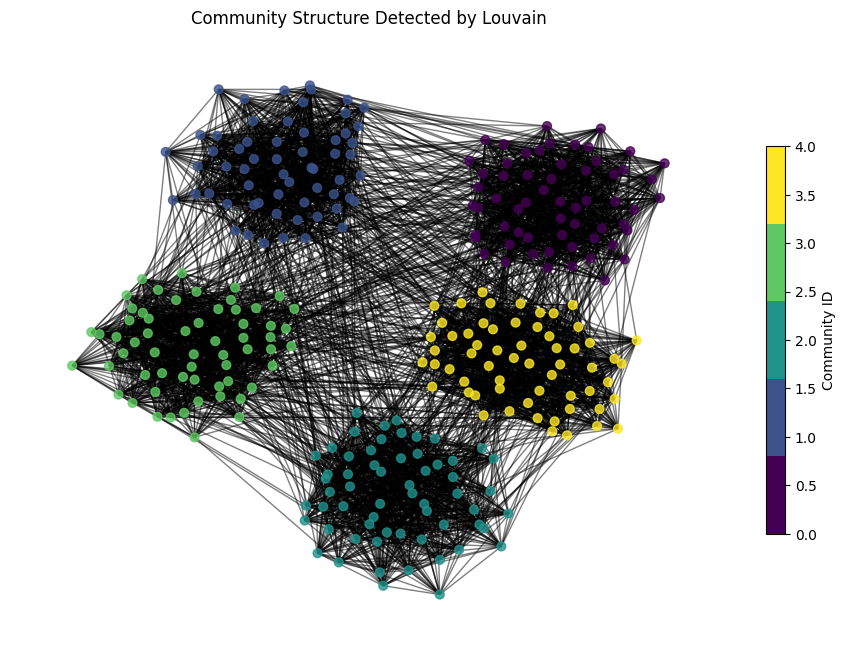

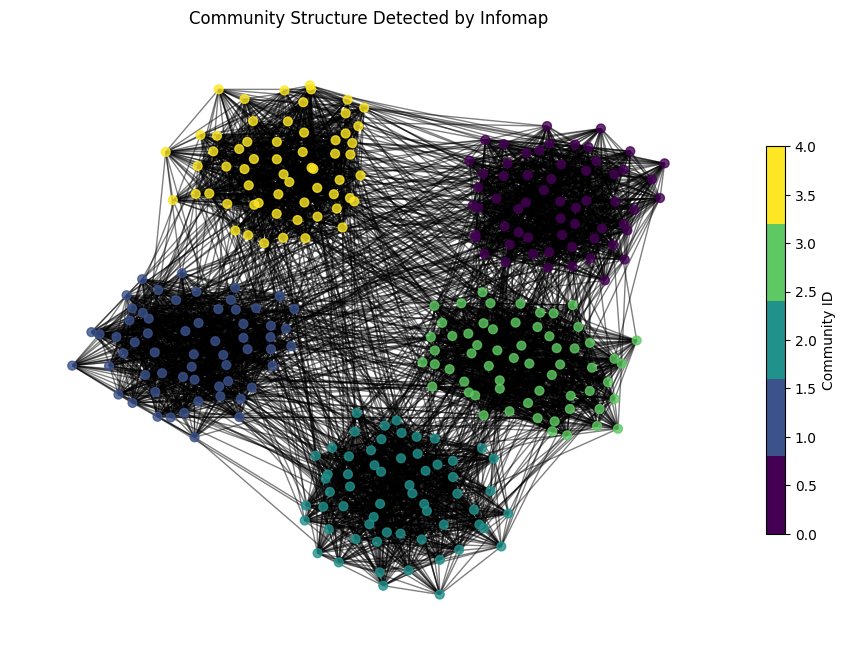

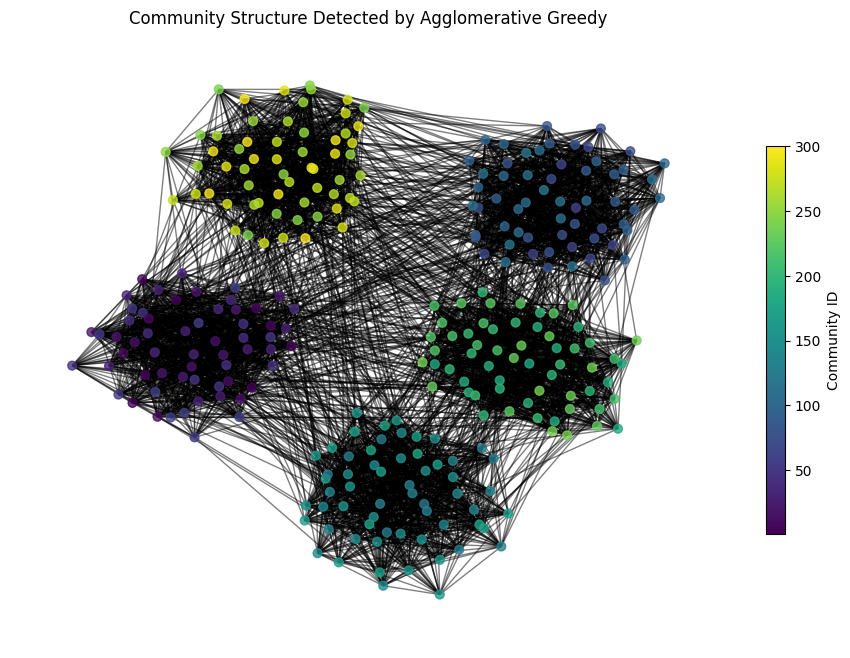

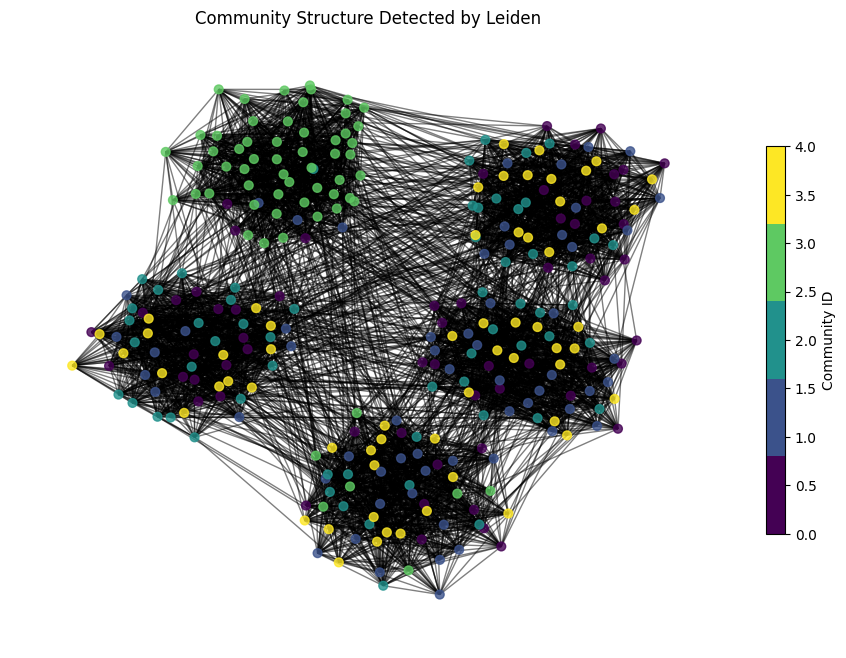

In [3]:
visualize_communities(G, louvain_partition, "Community Structure Detected by Louvain")
visualize_communities(G, infomap_partition, "Community Structure Detected by Infomap")
visualize_communities(G, ag_partition, "Community Structure Detected by Agglomerative Greedy")
visualize_communities(G, leiden_partition, "Community Structure Detected by Leiden")

In [ ]:
import networkx as nx

def girvan_newman_community_detection(G, num_communities=2):
    from networkx.algorithms.community import girvan_newman
    communities_generator = girvan_newman(G)
    top_level_communities = next(communities_generator)
    next_level_communities = next(communities_generator)
    # Choose the level of communities to return based on your num_communities parameter
    if num_communities == 2:
        return {node: idx for idx, community in enumerate(top_level_communities) for node in community}
    else:
        return {node: idx for idx, community in enumerate(next_level_communities) for node in community}

# Example usage
# Adjust num_communities based on how many splits you want to examine initially
gn_partition = girvan_newman_community_detection(G, num_communities=2)
visualize_communities(G, gn_partition, "Community Structure Detected by Girvan-Newman")


In [114]:
def jaccard_index(set1, set2):
    """Calculate the Jaccard Index between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    if union == 0:
        return 0
    else:
        return intersection / union


In [115]:
def partition_to_sets(partition):
    """Convert a partition dictionary to a list of sets."""
    from collections import defaultdict
    community_dict = defaultdict(set)
    for node, community in partition.items():
        community_dict[community].add(node)
    return list(community_dict.values())

In [116]:
from sklearn.metrics import jaccard_score
def compare_communities(community_sets_true, community_sets_computed):
    """Compare two lists of community sets and return average Jaccard Index."""
    jaccard_scores = []
    for set_true in community_sets_true:
        max_jaccard = 0
        for set_computed in community_sets_computed:
            score = jaccard_index(set_true, set_computed)
            if score > max_jaccard:
                max_jaccard = score
        jaccard_scores.append(max_jaccard)
    return sum(jaccard_scores) / len(jaccard_scores) if jaccard_scores else 0


In [118]:
# Convert partitions to sets of communities
true_sets = partition_to_sets(true_partition)
computed_sets = partition_to_sets(louvain_partition)

# Calculate Jaccard Index
jaccard_score = compare_communities(true_sets, computed_sets)
print("Jaccard Index:", jaccard_score)

Jaccard Index: 1.0
